<a href="https://colab.research.google.com/github/Arthur-ca/MIE1517/blob/Jing-Guo/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import numpy as np
import os
from sklearn.model_selection import train_test_split
import random
import torchvision
from torchvision import datasets, models
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torchvision.utils import save_image
import cv2 as cv
#from torchvision import transforms
from torch.utils.data.dataset import random_split
from collections import Counter
import imgaug.augmenters as iaa

In [24]:
#First link it to google drive and check the subfolder of the data
from google.colab import drive
drive.mount('/content/gdrive')
drive_content = os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive')
print(drive_content)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
['neutrality', 'sadness', 'fear', 'surprise', 'contempt', 'happiness', 'anger', 'disgust']


In [ ]:
# Normalize a tensor image with mean and standard deviation. This transform does not support PIL Image.
# Note that we have 3 values to mean and std cuz our img contains 3 channels so we have mean,std for each channel
# the equation will applied is (pixel_value - channel_mean / channel_std)

Normalize_Transformation = transforms.Compose([
    transforms.ToPILImage(),# first we need to convert our img to PIL format which can work with transforms
    transforms.ToTensor(),# we need to convert PIL img to tensor because normalize doesn't support PIL imgs
    transforms.Normalize(mean=[5,0.9,0.6], std=[1.45,0.21,7.12]),
    transforms.ToPILImage()# after normalize we convert again to PIL img, which enable us to show the img
])

# Testing The Transformation...
Normalized_Img = Normalize_Transformation(Cat_2)
Show_Image(Cat_2, 'Original Image')
Show_Image(Normalized_Img, 'Normalized Image')

In [25]:
import tensorflow as tf
import gc
import torchvision.transforms as transforms
from PIL import Image
from collections import Counter

In [26]:
classes = []
for i in os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive'):
    if i!=5:
        classes.append(i)
classes

['neutrality',
 'sadness',
 'fear',
 'surprise',
 'contempt',
 'happiness',
 'anger',
 'disgust']

In [29]:
# Define the classes (folders) in your dataset
classes = os.listdir('/content/gdrive/My Drive/ColabNotebooks/archive')

# Initialize empty lists for features (transformed images) and labels
features = []
labels = []
train_data = []

# Define the transformations
# data_transform1 = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ColorJitter(hue=0.05, saturation=0.05),
# ])
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Resize({"height": 224, "width": 224}),
            iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
            iaa.Sometimes(0.25, iaa.Affine(rotate=(-20, 20), mode='symmetric')),
            iaa.Sometimes(0.25, iaa.OneOf([
                iaa.Dropout(p=(0, 0.1)),
                iaa.CoarseDropout(0.1, size_percent=0.5)
            ])),
            iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
        ])

    def __call__(self, img):
        img = np.array(img)
        return self.aug.augment_image(img)

# data_transform3 = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomRotation(degrees=66)
# ])

data_transform3 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=(-50, 50))
])

data_transform4 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(5)  # The argument here specifies the radius, not kernel size
])

imgaug_transform = ImgAugTransform()
def create_train():
    for i, photo in enumerate(classes):
        path = os.path.join('/content/gdrive/My Drive/ColabNotebooks/archive', photo)
        label = i  # Use the index of the class as the label

        # Loop over to get every image in the current class
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img_array = cv.imread(img_path)

            if img_array is None:
                print("Error loading image:", img_path)
                continue

            # Append the original image and its label to the list
            features.append(np.array(img_array))
            labels.append(label)

            # Apply the defined transformations
            img_pil = Image.fromarray(cv.cvtColor(img_array, cv.COLOR_BGR2RGB))
            transformed_image1 = imgaug_transform(img_pil)
            transformed_image3 = data_transform3(img_pil)
            #transformed_image4 = normalize_transform(img_pil)

            # Append only the transformed image and its label to the lists
            features.append(np.array(transformed_image1))
            features.append(np.array(transformed_image3))
            #features.append(np.array(transformed_image4))
            labels.append(label)
            labels.append(label)
            train_data.append([img_array, label])
            train_data.append([transformed_image1, label])
            train_data.append([transformed_image3, label])
            #train_data.append([transformed_image4, label])
create_train()

# Count the occurrences of each label
label_counts = Counter(labels)

# Print the label counts
for label, count in label_counts.items():
    print(f"Label {label}: {count} images")

Label 0: 1572 images
Label 1: 2238 images
Label 2: 1710 images
Label 3: 2355 images
Label 4: 624 images
Label 5: 4218 images
Label 6: 2670 images
Label 7: 1317 images


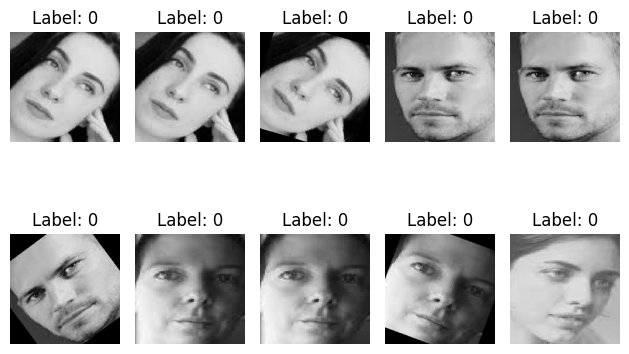

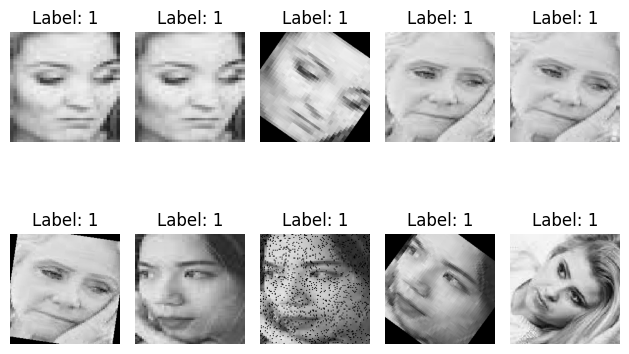

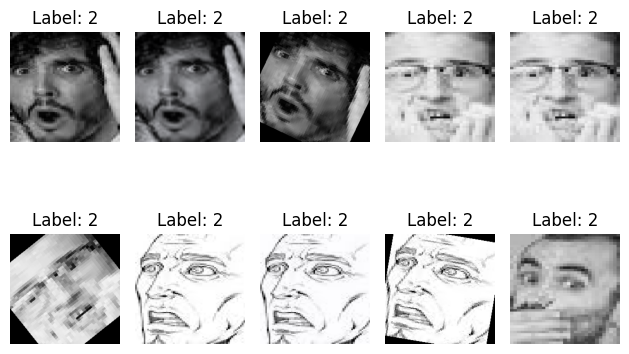

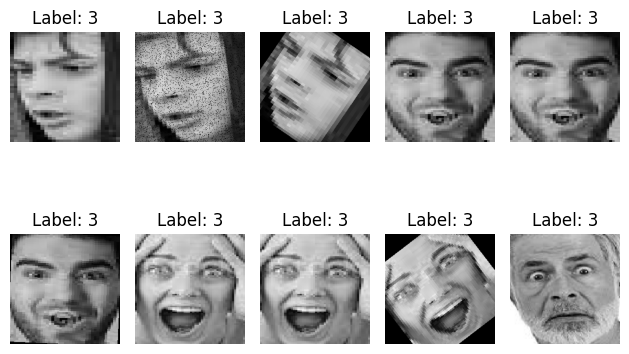

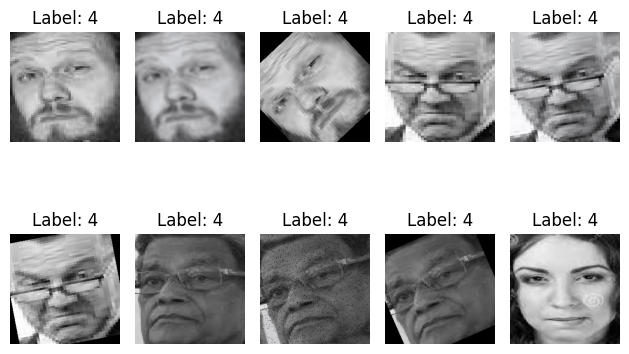

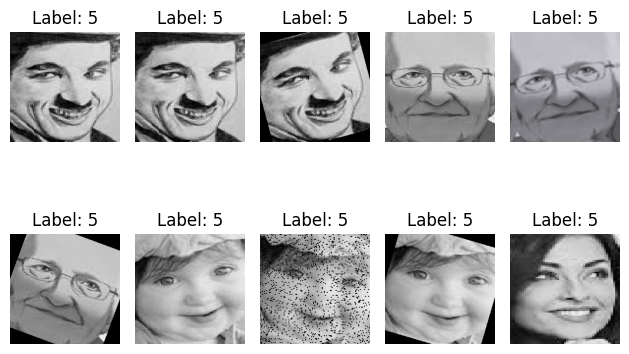

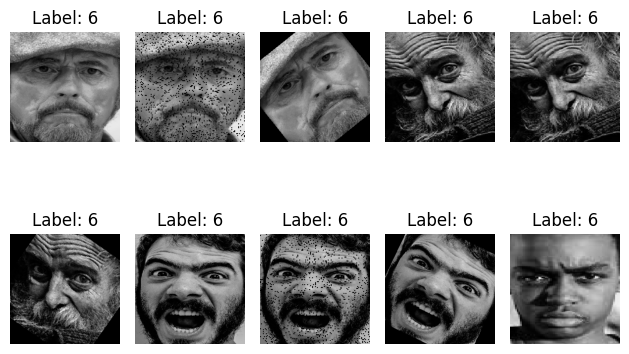

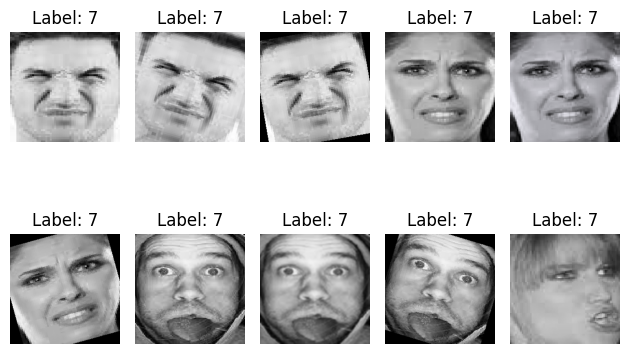

In [31]:
for labelt in range(8):
    plot_count = 0
    for image_array, label in train_data:
        if label == labelt and plot_count < 10:
            plt.subplot(2, 5, plot_count + 1)  # Create a 2x5 grid of subplots
            # Convert the PIL Image to a NumPy array and then convert BGR to RGB
            img_np = np.array(image_array)
            img_rgb = cv.cvtColor(img_np, cv.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f"Label: {label}")
            plt.axis('off')  # Turn off axis labels
            plot_count += 1

        if plot_count == 10:
            break

    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()

In [32]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Define the ratio for splitting the data
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Convert features and labels to PyTorch tensors
features = torch.tensor(features)
labels = torch.tensor(labels)

# Combine features and labels into a single dataset
dataset = TensorDataset(features, labels)

# Calculate the sizes for each split
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader objects for each split
batch_size = 64  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Now you have three data loaders: train_loader, val_loader, and test_loader


<ipython-input-32-db5851618038>:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  features = torch.tensor(features)


In [50]:
sample_index = 0  # Change this to the index of the sample you want to inspect
sample_data, sample_label = test_dataset[sample_index]

print("Sample data shape:", sample_data.shape)
print("Sample label:", sample_label)
print(len(test_dataset))



Sample data shape: torch.Size([224, 224, 3])
Sample label: tensor(0)
2507


In [35]:
from torchvision import transforms
from collections import defaultdict


# Assuming you have a list of labels and features, for example:
# labels = [0, 1, 0, 2, 1, 2, ...]  # Labels for each image
# features = [img1, img2, img3, img4, img5, img6, ...]  # List of images (e.g., numpy arrays)

# Shuffle the labels and features in the same order
combined = list(zip(labels, features))
random.shuffle(combined)
labels, features = zip(*combined)

# Create a dictionary to store images by label
label_to_images = defaultdict(list)

# Group images by label
for label, img in zip(labels, features):
    label_to_images[label].append(img)

# Set the ratios for train, validation, and test sets
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

train_data = []
validation_data = []
test_data = []

# Split data for each label
for label, images in label_to_images.items():
    random.shuffle(images)  # Shuffle the images for each label

    num_images = len(images)
    num_train = int(train_ratio * num_images)
    num_validation = int(validation_ratio * num_images)
    num_test = num_images - num_train - num_validation

    train_data.extend([(img, label) for img in images[:num_train]])
    validation_data.extend([(img, label) for img in images[num_train:num_train + num_validation]])
    test_data.extend([(img, label) for img in images[num_train + num_validation:]])

# Now, 'train_data', 'validation_data', and 'test_data' contain the shuffled split data without converting to tensors again.



In [39]:
batch_size = 64  # You can adjust the batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [66]:
class CNNLargeNet(nn.Module):
    def __init__(self, output1, output2):
        super(CNNLargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, output1, 9)  # Adjust in_channels and kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(output1, output2, 9)  # Adjust in_channels
        self.fc1 = nn.Linear(output2 * 50 * 50, 128)  # Adjust input size
        self.fc2 = nn.Linear(128, 9)  # 9 output classes
        self.output2 = output2  # Store output2 as an attribute of the class
        for param in self.parameters():
            param.data = param.data.to(torch.float32)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #x = x.view(-1, self.output2 * 50 * 50)  # Access output2 using self.output2
        x = x.reshape(-1, self.output2 * 50 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [41]:
# class CNNLargeNet(nn.Module):
#     def __init__(self, output1, output2):
#         super(CNNLargeNet, self).__init__()
#         self.name = "large"
#         self.conv1 = nn.Conv2d(3, output1, 9,2)  # Adjust in_channels and kernel size
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(output1, output2, 9,2)  # Adjust in_channels
#         self.fc1 = nn.Linear(output2 * 13 * 13, 128)  # Adjust input size
#         self.fc2 = nn.Linear(128, 9)  # 9 output classes
#         self.output2 = output2  # Store output2 as an attribute of the class

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, self.output2 * 13 * 13)  # Access output2 using self.output2
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

In [36]:

def get_accuracy(model, dataset):
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(dataset, batch_size=64):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [37]:
def trainmodel(model, train_dataset, val_dataset, batch=64, learningRate=0.001, num_epochs=10):
    # Create loss function and optimizer.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learningRate)
    # Load data
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=True)
    # Create accuracy lists
    iters, losses, train_accuracy, validation_accuracy = [], [], [], []
    n = 0  # Initialize the iteration counter
    # Train the data
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch_data in train_loader:
            imgs, labels = batch_data
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            out = model(imgs)  # Forward pass
            loss = criterion(out, labels)  # Compute the total loss
            loss.backward()  # Backward pass (compute parameter updates)
            optimizer.step()  # Make the updates for each parameter
            optimizer.zero_grad()  # A clean-up step for PyTorch
            n += 1

            # Save the current training information
            running_loss += loss.item()

        iters.append(n)
        losses.append(running_loss / len(train_loader))  # Compute average loss for the epoch
        train_accuracy.append(get_accuracy(model, train_dataset))  # Compute training accuracy

        # Compute validation accuracy for this epoch
        validation_accuracy.append(get_accuracy(model, val_dataset))  # Compute validation accuracy

        # Print progress for the epoch
        print("Epoch {}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%".format(
            epoch, train_accuracy[epoch], validation_accuracy[epoch]))

        # Save model checkpoint
        model_checkpoint_path = '/content/gdrive/My Drive/ColabNotebooks/new'  # You can change the directory as needed
        model_checkpoint_file = os.path.join(model_checkpoint_path, f'{model.name} =Batch_size_{batch}_model_epoch{epoch + 1}.pth')
        torch.save(model.state_dict(), model_checkpoint_file)
        print(f"Saved model checkpoint: {model_checkpoint_file}")

    print("Finished Training")
    return iters, losses, train_accuracy, validation_accuracy

In [64]:

def trainSmall(model, data, batch_size=32, learning_rate=0.001, num_epochs=10):
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_acc = []
    # training
    print("Training Start")
    n = 0  # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            #############################################
            # To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################
            imgs = imgs.to(torch.float32)  # Cast input images to torch.float32
            # Assuming 'imgs' is your input data with shape [32, 224, 224, 3]
            imgs = imgs.permute(0, 3, 1, 2)  # Change from [32, 224, 224, 3] to [32, 3, 224, 224]
            out = model(imgs)  # forward pass
            loss = criterion(out, labels)  # compute the total loss
            loss.backward()  # backward pass (compute parameter updates)
            optimizer.step()  # make the updates for each parameter
            optimizer.zero_grad()  # a clean-up step for PyTorch
            n += 1

        train_accuracy = get_accuracy(model, data)
        train_acc.append(train_accuracy)
        print("Epoch:{}, Accuracy:{}".format(epoch, train_accuracy))
    return train_acc


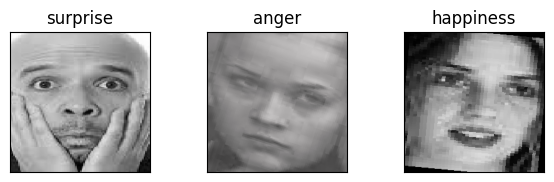

In [59]:
#Small Size
# Transform Settings

batch_size = 3
num_workers = 1
small_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Visualize some sample data
classes = ['neutrality', 'sadness', 'fear', 'surprise', 'contempt', 'happiness', 'anger', 'disgust']
dataiter = iter(small_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(3):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])  #np.transpose(images[idx], (1, 2, 0))
    ax.set_title(classes[labels[idx]])

In [67]:
use_cuda = True
CNNmodel = CNNLargeNet(10,20)
Y = trainSmall(CNNmodel,test_dataset,num_epochs=21)

Training Start


RuntimeError: ignored